# Graph-based image segmentation
---

The following code is based on the graph-based segmentation algorithm proposed by Felzenszwalb et. al. ([paper](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf)).

## Description of the algorithm

Let's consider a grayscale image of size `NxM`, being N the height of the image and M its width. Each pixel of the image has a value between 0 and 255.

The algorithm treats each pixel as a node of a graph `G = (V,E)` where:
- `V` is the set of vertices
- `E` the set of edges (i.e. connections between a pair of nodes).

Each edge has an associated weight which - in the case of this implementation - is the *intensity distance* between the considered pair of nodes.

The pixels are connected in a 8-grid fashion: this means that each pixel is connected to its 8 neighbors.

We start by considering each node of the graph as a singleton component (at the beginning we have `height * width` components) and we merge them is an agglomerative way according to the so called *boundary evidence*.

That is: at each step of the algorithm, two components are compared and, if a boundary evidence is present, they are keep separated, otherwise they are merged into one single components. Doing so, we can reduce the number of components step-by-step reaching a final result in which each component represents a logic instance in the image.

The boundary evidence is defined as the inequality between two quantities:
- `Dif(C1, C2)`: represents the within-difference between the two components `C1` and `C2`
- `MInt(C1, C2)`: represents the inter-component difference

For more details see the [paper](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf).

For our purpose it is important to notice that the threshold depends on a parameter `k` which can be considered as a *tuning* parameter:
- larger `k`: preference for larger components
- smaller `k`: preference for smaller components

In [1]:
import numpy as np
from PIL import Image, ImageFilter
import time

### Disjoint-set forest

The components are well represented using the *disjoint-set forest* data structure:
- it stores a collection of disjoint non-overlapping sets (or a partition of a set into disjoint subsets).
- provides operations for:
    - adding new sets
    - merging sets (replacing them by their union) 
    - find a representative member of a set. 


It works as follows:
- the set is initialized with `N * M` nodes, each of one is initially considered as a single components (or subset)
- each component has a representative/parent which is the one having greater rank
- when two components are merged into a single one, the one having greater rank is considered the parent of the other
- the size of a component indicats the number of nodes inside it


In [2]:
class DisjointSetForest:
    """ Disjoint-set forest data structure (https://en.wikipedia.org/wiki/Disjoint-set_data_structure).
    Stores a collection of disjoint non-overlapping sets (or a partition of a set into disjoint subsets).
    Provides operations for adding new sets, merging sets (replacing them by their union) and find a 
    representative member of a set. 
    """

    # Class members
    parent = None       # list providing the parent of the indexed node (list)
    rank = None         # list providing the rank of the indexed node (list)
    size = None         # list providing the size of the child tree of the indexed node (list)
    num_sets = None     # number of subsets (int)


    def __init__(self, num_nodes: int):
        """ Disjoint-set forest class constructor.

        Args:
            num_nodes (int): total number of elements to be partitioned.
        """
        self.parent = [i for i in range(num_nodes)]
        self.rank = [0 for i in range(num_nodes)]
        self.size = [1 for i in range(num_nodes)]
        self.num_sets = num_nodes


    
    def size_of(self, u: int):
        """ Return the size of the child tree of the given component 
        
        Args:
            u (int): node of which we want to know the size.
        
        Returns:
            size (int): number of nodes in the subtree of u.    
        """
        return self.size[u]



    def find(self, u: int):
        """ Return the representative of a subset.

        Args:
            u (int): node of which we want to know the representative.

        Returns:
            representative of the subset/node.
        """
        if self.parent[u] == u:
            return u

        self.parent[u] = self.find(self.parent[u])
        return self.parent[u]



    def merge(self, u: int, v: int):
        """ Merge two nodes/subsets into one based on their rank.

        Args:
            u (int): first node/subset
            v (int): second node/subset
        """
        u = self.find(u)
        v = self.find(v)

        if u != v:
            if self.rank[u] > self.rank[v]:
                u, v = v, u

            self.parent[u] = v
            self.size[v] += self.size[u]
            if self.rank[u] == self.rank[v]:
                self.rank[v] += 1

            self.num_sets -= 1

### Graph

The implementation of the `ImageGraph` class is useful to convert an input image into a graph which can be exploited to run the graph-based segmentation algorithm.

The class provides the following methods:
- `_preprocessing()`: converts an input RGB image to a grayscale Numpy array and applies a Gaussian filter.
- `_get_diff(pixel1, pixel2)`: returns the difference in terms of intensity between the given pixels.
- `_create_edge(pixel1, pixel2)`: creates the edge between two pixels of the input image.
- `_threshold(k, size)`: defines the threshold for a component havig size = size with the constant k (`t = k/size`).
- `build_graph()`: builds the graph (list of tuples) from the input image, adding the necessary edges.
- `sort()`: sorts the graph according to the weights of the edges (non-decreasing order).
- `segment(k, min_size)`: segments the image applying the algorithm and removes the component with `size < min_size`.
- `generate_image()`: generates the segmented image.

In [3]:
class ImageGraph:
    """ Graph built by an input image.
    Each pixel is a vertex of G = (V, E) where G is the graph, V is the set of
    vertices and E is the set of edges. Each pixel is connected to its neighbors in
    an 8-grid sense.
    """

    # Class members
    filepath = None         # image filepath (str)
    img = None              # original image (PIL.Image)
    processed_arr = None    # preprocessed array (np.ndarray)
    segmented_img = None    # segmented image (PIL.Image)
    segmented_arr = None    # segmented array (np.ndarray)
    height = None           # image height (int)
    width = None            # image width (int)
    num_nodes = None        # number of nodes (a.k.a. number of pixels) (int)
    graph = None            # graph of the image (list)
    sorted_graph = None     # sorted graph by non-decreasing order of edges' weight
    components = None       # Disjoint-set forest containing the components of the segmentation
    threshold = None        # threshold for each component: k/|C| (int)


    def __init__(self, img: str or np.ndarray, preprocessing: bool=True):
        """ ImageGraph class constructor.

        Args:
            img (str or np.ndarray): path to the input image (if preprocessing == True)
                                     or np.ndarray of the input image (already preprocessed)
            preprocessing (bool): (default=True) to be applied if the image has not been preprocessed yet
        """
        if type(img) == str:
            self.img = Image.open(img)
            self.filepath = img
        elif type(img) == np.ndarray:
            self.img = Image.fromarray(img)
        else:
            raise ValueError("Wrong image type: must be either str or np.ndarray.")

        if preprocessing:
            self.processed_arr = ImageGraph._preprocessing(self.img)
        else:
            self.processed_arr = self.img

        self.height, self.width = self.processed_arr.shape
        self.num_nodes = self.height * self.width
    


    @staticmethod
    def _preprocessing(img: Image, resize: bool=True, gaussian_blur: bool=True,):
        """ Convert an input RGB image to a grayscale Numpy array and apply a Gaussian filter.

        Args:
            img (PIL.Image): image to be processed
            resize (bool): (default=True) whether to resize the image or not
            gaussian_blur (bool): (default=True) whether to apply the Gaussian Blur or not
        
        Returns:
            img (np.ndarray): Numpy array represented the processed image
        """
        img = img.convert("L")

        if resize:
            new_width  = 300
            percentage = float(new_width/img.size[0])
            new_height = int((float(img.size[1])*float(percentage)))
            img = img.resize((new_width, new_height), Image.ANTIALIAS)
        
        if gaussian_blur: 
            img = img.filter(ImageFilter.GaussianBlur(1.5))
        
        return np.array(img)



    @staticmethod
    def _get_diff(img: np.ndarray, u_coords: tuple, v_coords: tuple):
        """ Return the difference in terms of intensity between two pixels of an image.
        
        Args:
            img (numpy.ndarray): input grayscale image in array format (values from 0 to 255)
            u_coords (tuple): coordinates of first pixel (x1, y1)
            v_coords (tuple): coordinates of second pixel (x2, y2)

        Returns:
            diff (numpy.uint8): difference between the input pixels
        """
        height, width = img.shape
        x1, y1 = u_coords
        x2, y2 = v_coords
        
        # necessary check since pixels are uint8 (problem with abs)
        if img[y1, x1] > img[y2, x2]:
            return img[y1, x1] - img[y2, x2]
        
        return img[y2, x2] - img[y1, x1]



    @staticmethod
    def _create_edge(img: np.ndarray, u_coords: tuple, v_coords: tuple):
        """ Create the edge between two pixels of the input image.

        Args:
            img (numpy.ndarray): input grayscale image in array format (values from 0 to 255)
            u_coords (tuple): coordinates of first pixel (x1, y1)
            v_coords (tuple): coordinates of second pixel (x2, y2)

        Returns:
            id1 (int): first pixel id
            id2 (int): second pixel id
            weight (numpy.uint8): edge weight
        """
        _, width = img.shape

        vertex_id = lambda coords: coords[1] * width + coords[0]
        id1 = vertex_id(u_coords)
        id2 = vertex_id(v_coords)

        weight = ImageGraph._get_diff(img, u_coords, v_coords)
        
        return (id1, id2, weight)

    

    @staticmethod
    def _threshold(k: int, size: int):
        """ Define the threshold for a subset of cardinality given by size.

        Args:
            k (int): scale of observation (large k -> larger components)
            size (int): cardinality of the component into consideration
        
        Returns:
            threshold (int): threshold for a given component
        """
        return int(k/size)



    def build_graph(self):
        """ Build the graph.

        Returns:
            graph (list): list of tuples (u, v, weight) 
        """
        self.graph = []

        print("Building graph...")
        start = time.time()
        for y in range(self.height):
            for x in range(self.width):
                if x < self.width - 1:
                    u_coords = (x, y)
                    v_coords = (x + 1, y)
                    self.graph.append(ImageGraph._create_edge(self.processed_arr, u_coords, v_coords))
                if y < self.height - 1:
                    u_coords = (x, y)
                    v_coords = (x, y + 1)
                    self.graph.append(ImageGraph._create_edge(self.processed_arr, u_coords, v_coords))
                if x < self.width - 1 and y < self.height - 1:
                    u_coords = (x, y)
                    v_coords = (x + 1, y + 1)
                    self.graph.append(ImageGraph._create_edge(self.processed_arr, u_coords, v_coords))
                if x < self.width - 1 and y > 0:
                    u_coords = (x, y)
                    v_coords = (x + 1, y - 1)
                    self.graph.append(ImageGraph._create_edge(self.processed_arr, u_coords, v_coords))
        end = time.time()
        print("Graph built in {:.3}s.\n".format(end-start))
    

    def sort(self):
        """ Sort the graph by non-decreasing order of edges' weight.
        
        Returns:
            sorted_graph (list): sorted graph
        """
        self.sorted_graph = sorted(self.graph, key=lambda edge: edge[2])

    

    def segment(self, k, min_size: int=None):
        """ Segment the graph according to the graph-based segmentation algorithm
        proposed by Felzenszwalb et. al.

        Args:
            k (int): parameter for the threashold
            min_size (int): (default=None) if specified, the components having size less than min_size are removed
        
        Returns:
            components (DisjointSetForest): Disjoint-set Forest containing the segmented components
        """
        self.components = DisjointSetForest(self.num_nodes)
        threshold = [ImageGraph._threshold(k, i) for i in self.components.size]

        self.sort()

        print("Segmenting...")
        start = time.time()
        for edge in self.sorted_graph:
            u, v, w = edge

            u = self.components.find(u)
            v = self.components.find(v)

            if u != v:
                if w <= threshold[u] and w <= threshold[v]:
                    self.components.merge(u, v)
                    parent = self.components.find(u)
                    threshold[parent] = w + ImageGraph._threshold(k, self.components.size_of(u))
        end = time.time()
        print("Segmentation done in {:.3}s.\n".format(end-start))

        # remove components having size less than min_size
        if min_size != None:
            print("Removing componentes having size less than {}...".format(min_size))
            start = time.time()
            for edge in self.sorted_graph:
                u, v, _ = edge
                u = self.components.find(u)
                v = self.components.find(v)

                if u != v:
                    if self.components.size_of(u) < min_size or self.components.size_of(v) < min_size:
                        self.components.merge(u, v)
            end = time.time()
            print("Removed components in {:.3}s.\n".format(end-start))


    def generate_image(self):
        """ Generate the segmented image as a numpy array.

        Returns:
            segmented_arr (np.ndarray): segmented image array
            segmented_img (PIL.Image): segmented image

        """
        random_color = lambda: (int(np.random.rand() * 255), int(np.random.rand() * 255), int(np.random.rand() * 255))

        color = [random_color() for i in range(self.width * self.height)]

        self.segmented_arr = np.zeros((self.height, self.width, 3), np.uint8)

        print("Generating image...")
        start = time.time()
        for y in range(self.height):
            for x in range(self.width):
                color_idx = self.components.find(y * self.width + x)
                self.segmented_arr[y, x] = color[color_idx]
        
        self.segmented_img = Image.fromarray(self.segmented_arr)
        end = time.time()
        print("Image generated in {:.3}s.\n".format(end-start))

In [4]:
import os

directory = '../img/input/'
images = []
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        images.append(os.path.join(directory, filename))
    else:
        continue

igs = [None] * len(images)
for i in range(len(images)):
    print("\nImage {}\n".format(i))
    igs[i] = ImageGraph(images[i])
    igs[i].build_graph()
    igs[i].segment(k=3000, min_size=100)
    igs[i].generate_image()


Image 0

Building graph...
Graph built in 0.938s.

Segmenting...
Segmentation done in 1.32s.

Removing componentes having size less than 100...
Removed components in 0.396s.

Generating image...
Image generated in 0.205s.


Image 1

Building graph...
Graph built in 0.847s.

Segmenting...
Segmentation done in 1.29s.

Removing componentes having size less than 100...
Removed components in 0.387s.

Generating image...
Image generated in 0.198s.


Image 2

Building graph...
Graph built in 0.861s.

Segmenting...
Segmentation done in 1.25s.

Removing componentes having size less than 100...
Removed components in 0.399s.

Generating image...
Image generated in 0.196s.


Image 3

Building graph...
Graph built in 0.875s.

Segmenting...
Segmentation done in 1.28s.

Removing componentes having size less than 100...
Removed components in 0.395s.

Generating image...
Image generated in 0.198s.


Image 4

Building graph...
Graph built in 0.847s.

Segmenting...
Segmentation done in 1.29s.

Removing 

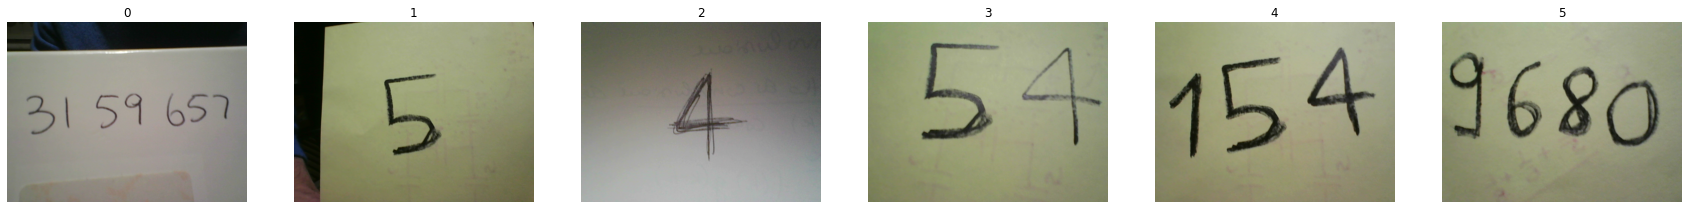

In [5]:
import matplotlib.pyplot as plt

n_images = len(images)

fig = plt.figure(figsize=(30,15))
for i in range(n_images):
    image = igs[i].img
    label = i
    sp = fig.add_subplot(2, 6, i+1)
    sp.set_title(label)
    plt.axis('off')
    plt.imshow(image)
plt.show()

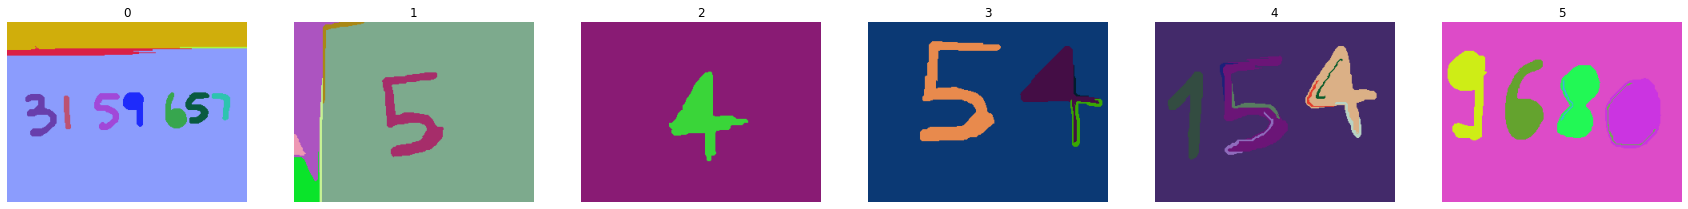

In [6]:
fig = plt.figure(figsize=(30,15))
for i in range(n_images):
    image = igs[i].segmented_img
    label = i
    sp = fig.add_subplot(2, 6, i+1)
    sp.set_title(label)
    plt.axis('off')
    plt.imshow(image)
plt.show()